In [1]:
import sys
import os

import numpy as np
import cv2
import torch
from torch.utils.data import DataLoader

sys.path.insert(0, os.path.abspath('..'))

from src.utils.load_cfg import ConfigLoader
from src.factories import ModelFactory
from src.factories import DatasetFactory
from src.utils.misc import MiscUtils

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})


dataset_cfg = '../configs/dataset_cfgs/epickitchens_short.yaml'
train_cfg = '../configs/train_cfgs/train_tbn_short.yaml'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Deprocess data for visualization
def deprocess_rgb(rgb, num_segments):
    rgb = rgb.cpu().numpy()
    assert rgb.shape[0] == 1
    _, _, h, w = rgb.shape
    rgb = rgb.reshape([num_segments, 3, h, w]).transpose(0, 2, 3, 1)
    rgb *= 1  # std
    rgb += np.array([104, 117, 128])  # mean
    rgb = rgb.astype(np.uint8)
    return rgb


def deprocess_spec(spec, num_segments):
    spec = spec.cpu().numpy()
    assert spec.shape[0] == 1
    _, _, h, w = spec.shape
    spec = spec.reshape([num_segments, h, w])
    return spec


def display_input(sample, num_segments):
    # Deprocess inputs
    rgb = deprocess_rgb(sample['RGB'], num_segments)
    spec = deprocess_spec(sample['Spec'], num_segments)

    # Display input RGB
    fig, axes = plt.subplots(1, num_segments, figsize=(20, 5))
    #fig.suptitle('='*30+'\n  RGB\n'+'='*30, fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_segments):
        axes[i].imshow(cv2.cvtColor(rgb[i], cv2.COLOR_BGR2RGB))
        #axes[i].axis('off')

    # Display input Spec
#     fig, axes = plt.subplots(1, num_segments, figsize=(10, 5))
#     fig.suptitle('='*30+'\n  Spec\n'+'='*30, fontsize=15)
#     fig.tight_layout()
#     fig.subplots_adjust(top=0.95)
#     for i in range(num_segments):
#         axes[i].imshow(spec[i], cmap='viridis')
#         axes[i].axis('off')

In [3]:
sample_id = 64
attention_layer = ['layer3', '0']


def load(model_cfg, dataset_cfg, train_cfg, new_num_segments=None):
    # Load configurations
    model_name, model_params = ConfigLoader.load_model_cfg(model_cfg)
    dataset_name, dataset_params = ConfigLoader.load_dataset_cfg(dataset_cfg)
    train_params = ConfigLoader.load_train_cfg(train_cfg)
    
    if new_num_segments is not None:
        model_params['num_segments'] = new_num_segments

    dataset_params.update({
        'modality': model_params['modality'],
        'num_segments': model_params['num_segments'],
        'new_length': model_params['new_length'],
    })

    # Build model
    model_factory = ModelFactory()
    model = model_factory.generate(model_name, device=device, model_factory=model_factory, **model_params)
    model.load_model(weight)
    model = model.to(device)

    # Get training augmentation and transforms
    train_augmentation = MiscUtils.get_train_augmentation(model.modality, model.crop_size)
    train_transform, val_transform = MiscUtils.get_train_val_transforms(
        modality=model.modality,
        input_mean=model.input_mean,
        input_std=model.input_std,
        scale_size=model.scale_size,
        crop_size=model.crop_size,
        train_augmentation=train_augmentation,
    )

    # Data loader
    dataset_factory = DatasetFactory()
    loader_params = {
        'batch_size': train_params['batch_size'],
        'num_workers': train_params['num_workers'],
        'pin_memory': True,
    }

    val_dataset = dataset_factory.generate(dataset_name, mode='val', transform=val_transform, **dataset_params)
    val_loader = DataLoader(val_dataset, shuffle=False, **loader_params)
    return model, val_loader


def run_experiment(model_cfg, weight, title='', display=False, new_num_segments=None):
    model, val_loader = load(model_cfg, dataset_cfg, train_cfg, new_num_segments)
    
    # Get a sample
    for i, (sample, target) in enumerate(val_loader):
        sample = {k: v.to(device) for k, v in sample.items()}
        target = {k: v.to(device) for k, v in target.items()}

        if i == sample_id:
            break
            
    if display:
        display_input(sample, model.num_segments)
    
    # Forward
    with torch.no_grad():
        model.eval()
        model(sample)
    
    # Get attention at all layers
    attn = model.light_model.rgb.get_all_attention_weights(aggregated=True)
    
    # Visualize
    for l_name in attn:
        fig, axes = plt.subplots(len(attn[l_name]), model.num_segments,
                                 figsize=(20, 3*len(attn[l_name])))
        fig.suptitle('='*30
                     +'\n  {} - {}\n'.format(l_name, list(attn[l_name]['0'].size()))
                     +'='*30, fontsize=15)
        for key in attn[l_name]:
            foo = attn[l_name][key].mean(dim=1).cpu().detach().numpy()
            for t in range(model.num_segments):
                axes[int(key), t].imshow(foo[t], vmin=foo.min(), vmax=foo.max())
            axes[int(key), 0].set_ylabel(key)

# 112x112

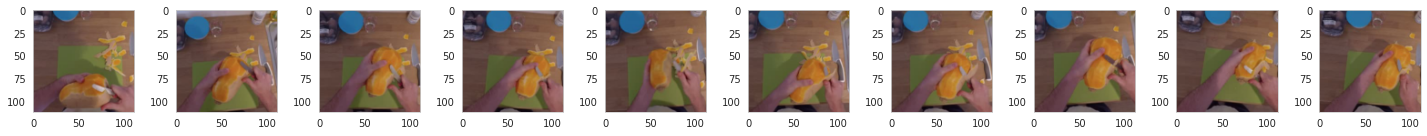

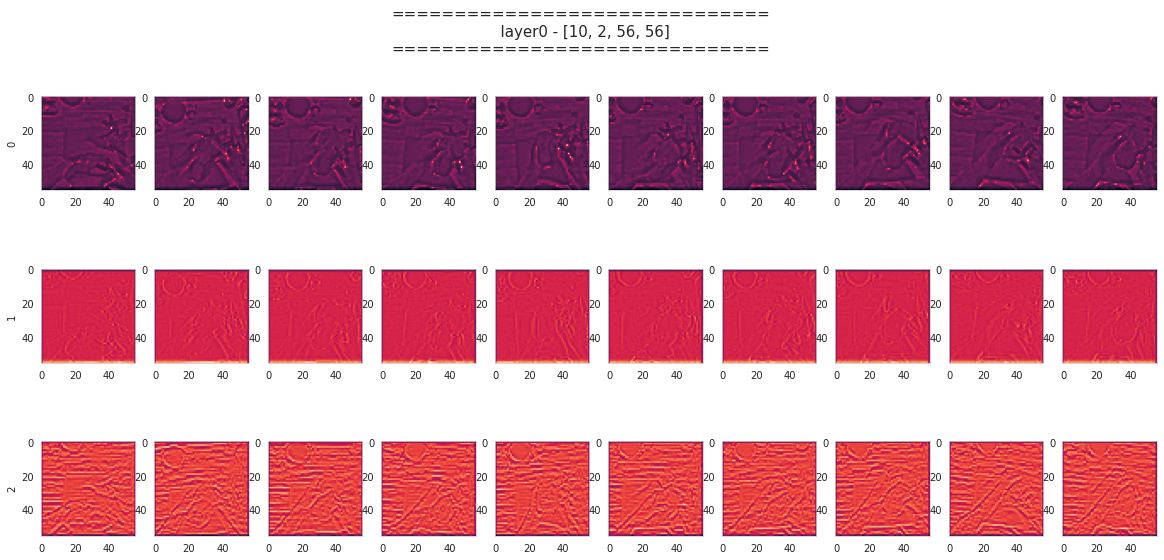

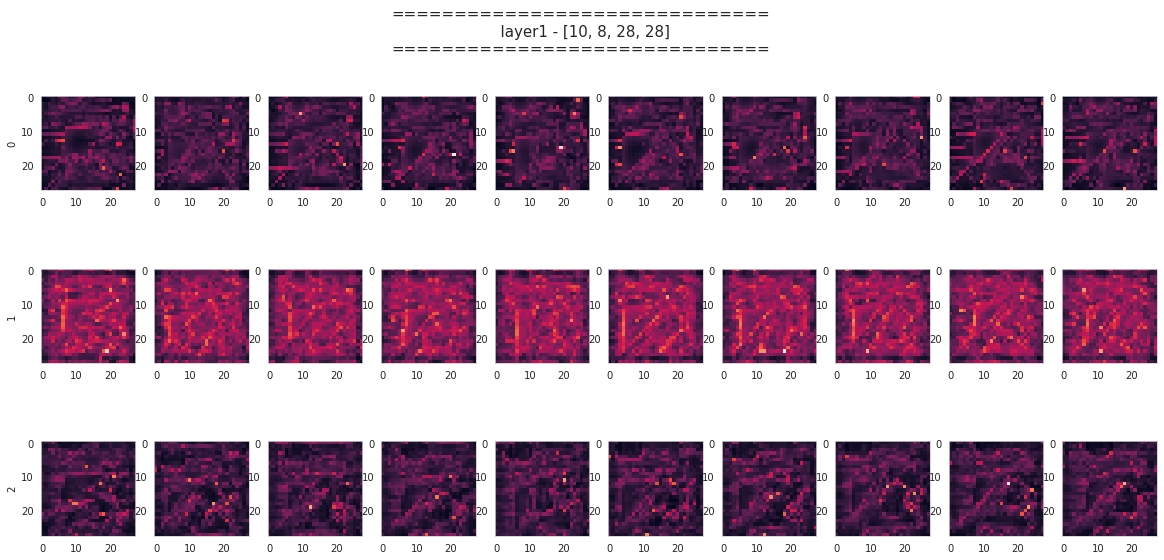

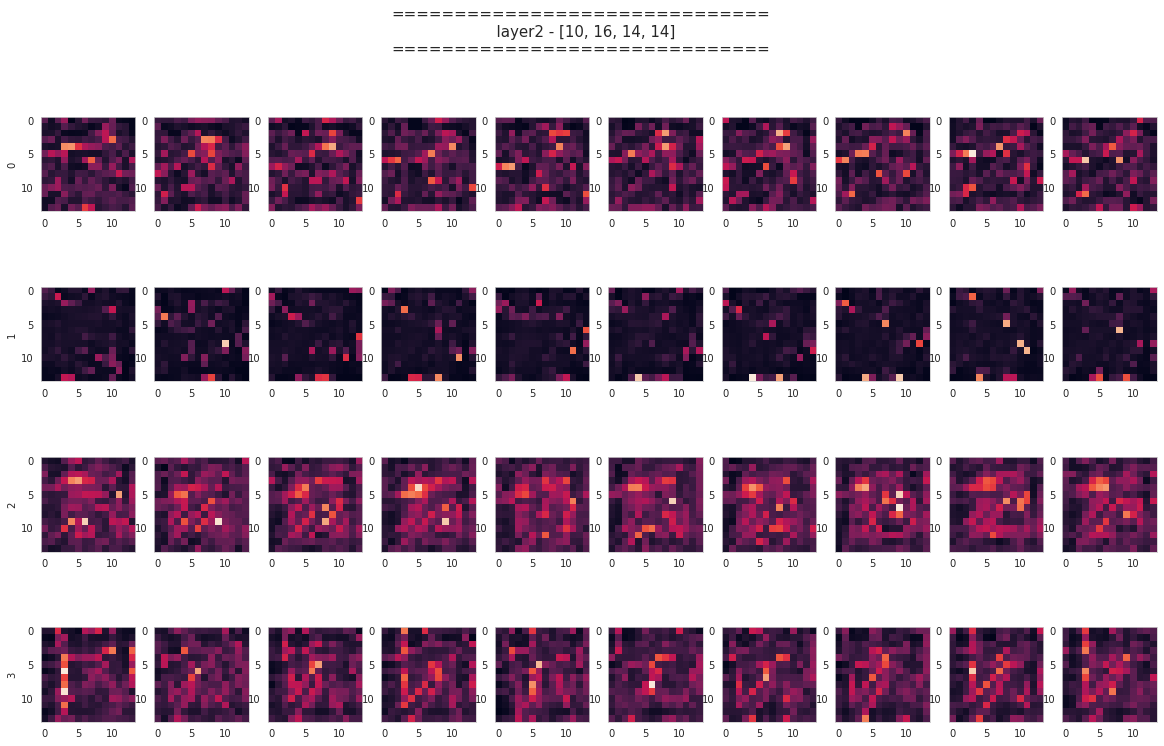

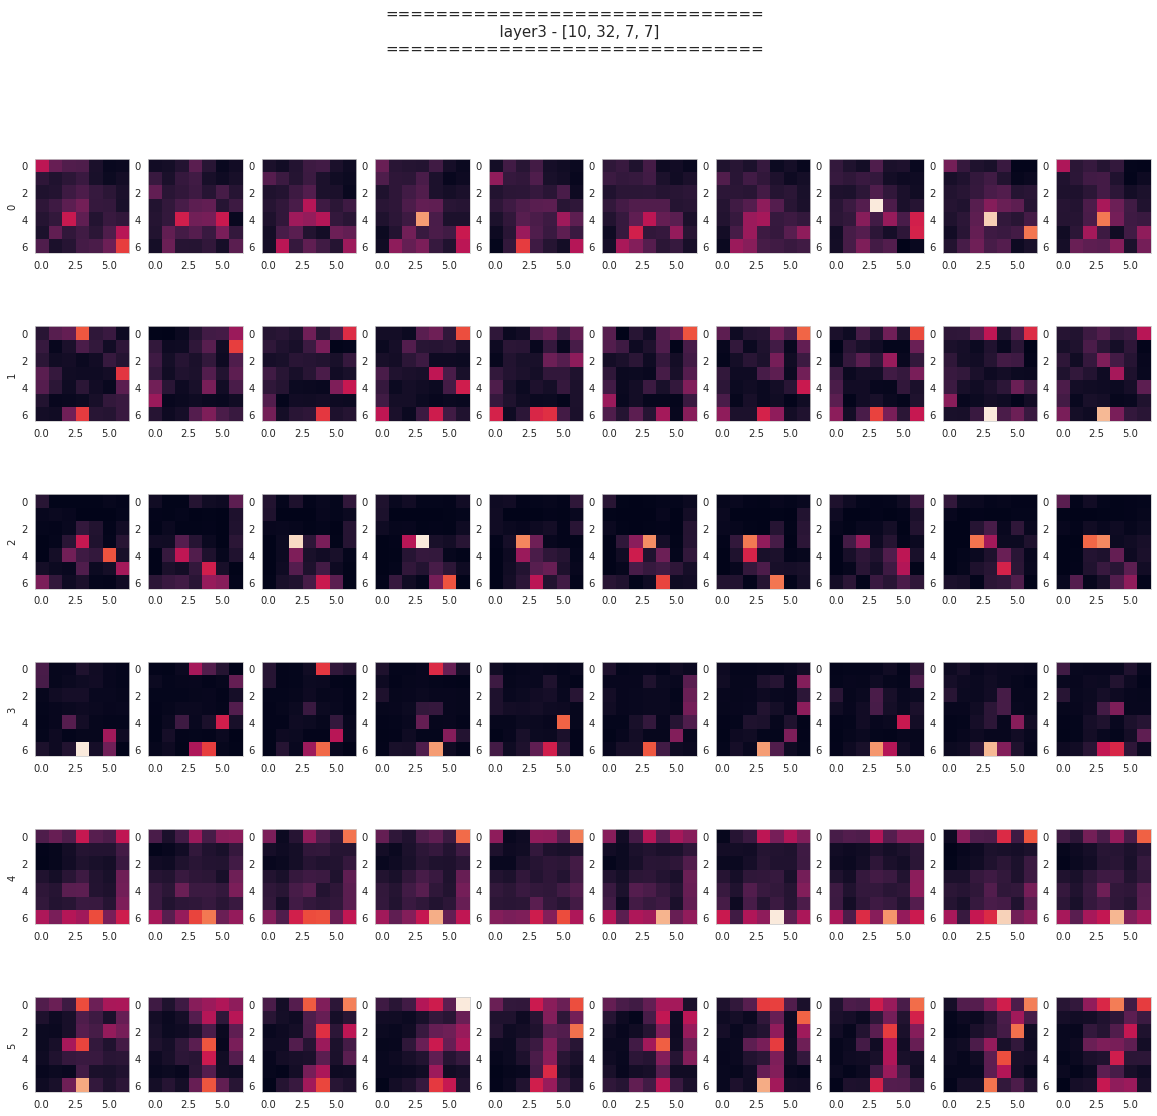

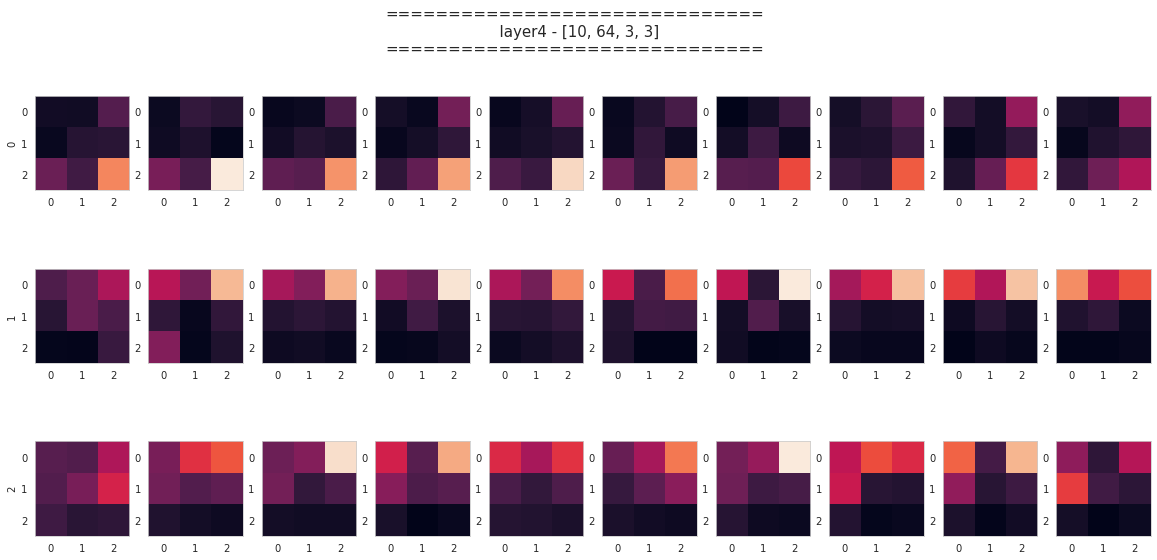

In [4]:
model_cfg = '../configs/model_cfgs/pipeline_simple_san19pair_rgbspec_112.yaml'
weight = '../pretrained/san19_epic_otherscales/112/best.model'
run_experiment(model_cfg, weight, title=weight.split('/')[-2], display=True, new_num_segments=10)

# 168x168

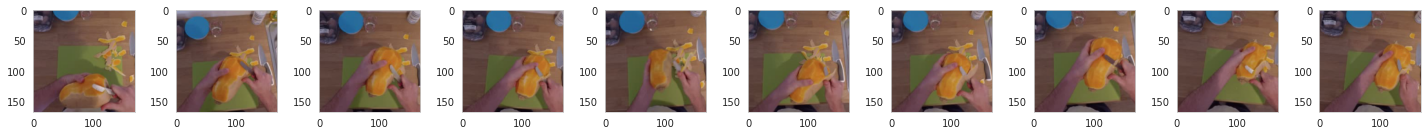

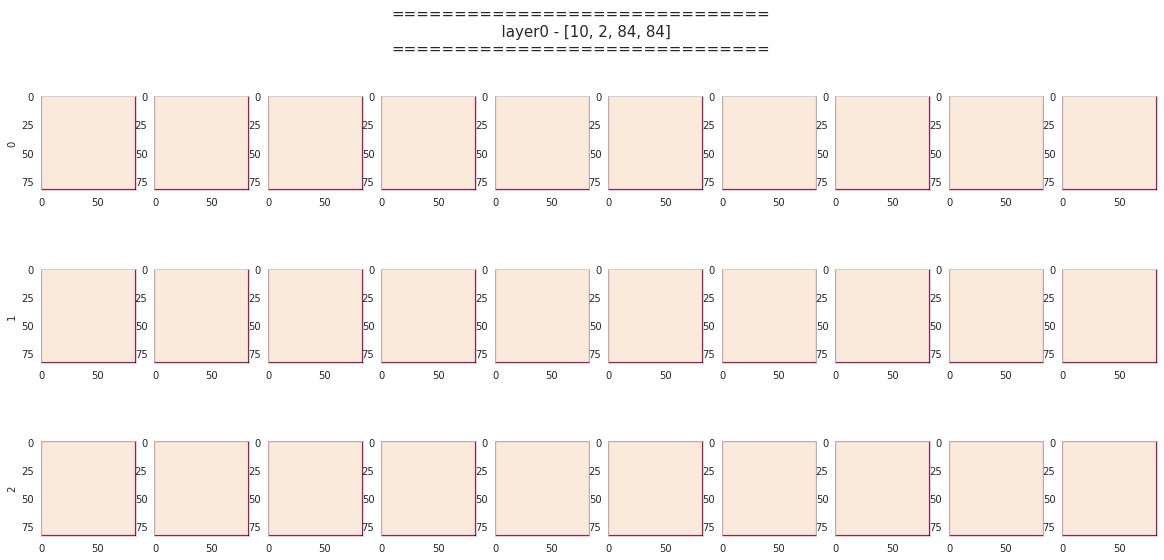

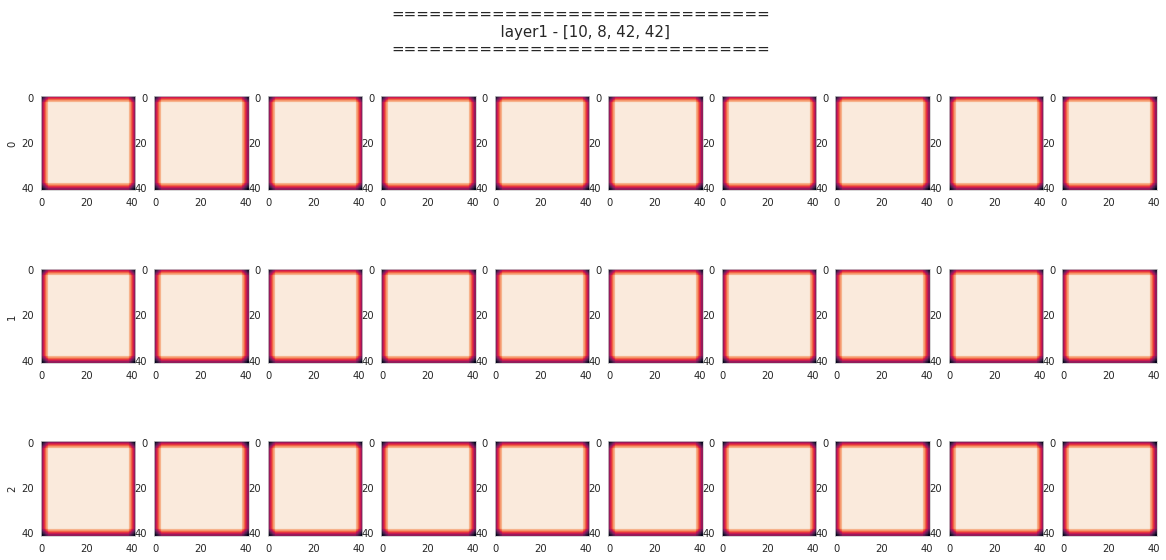

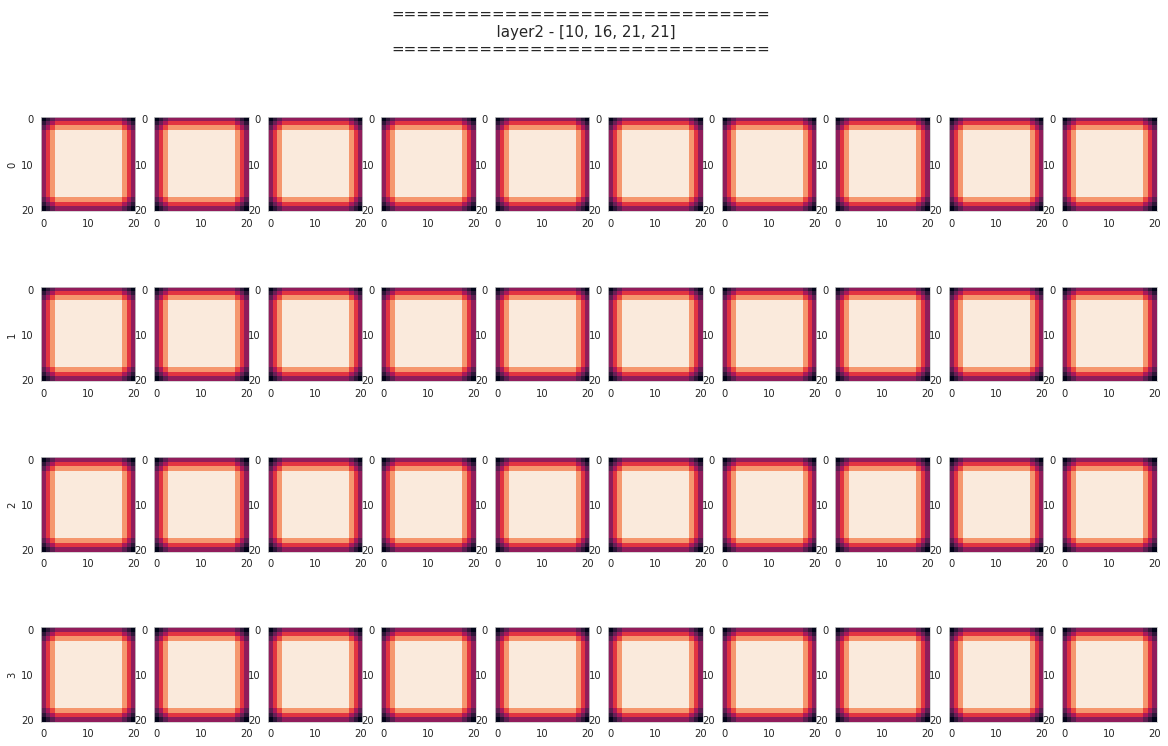

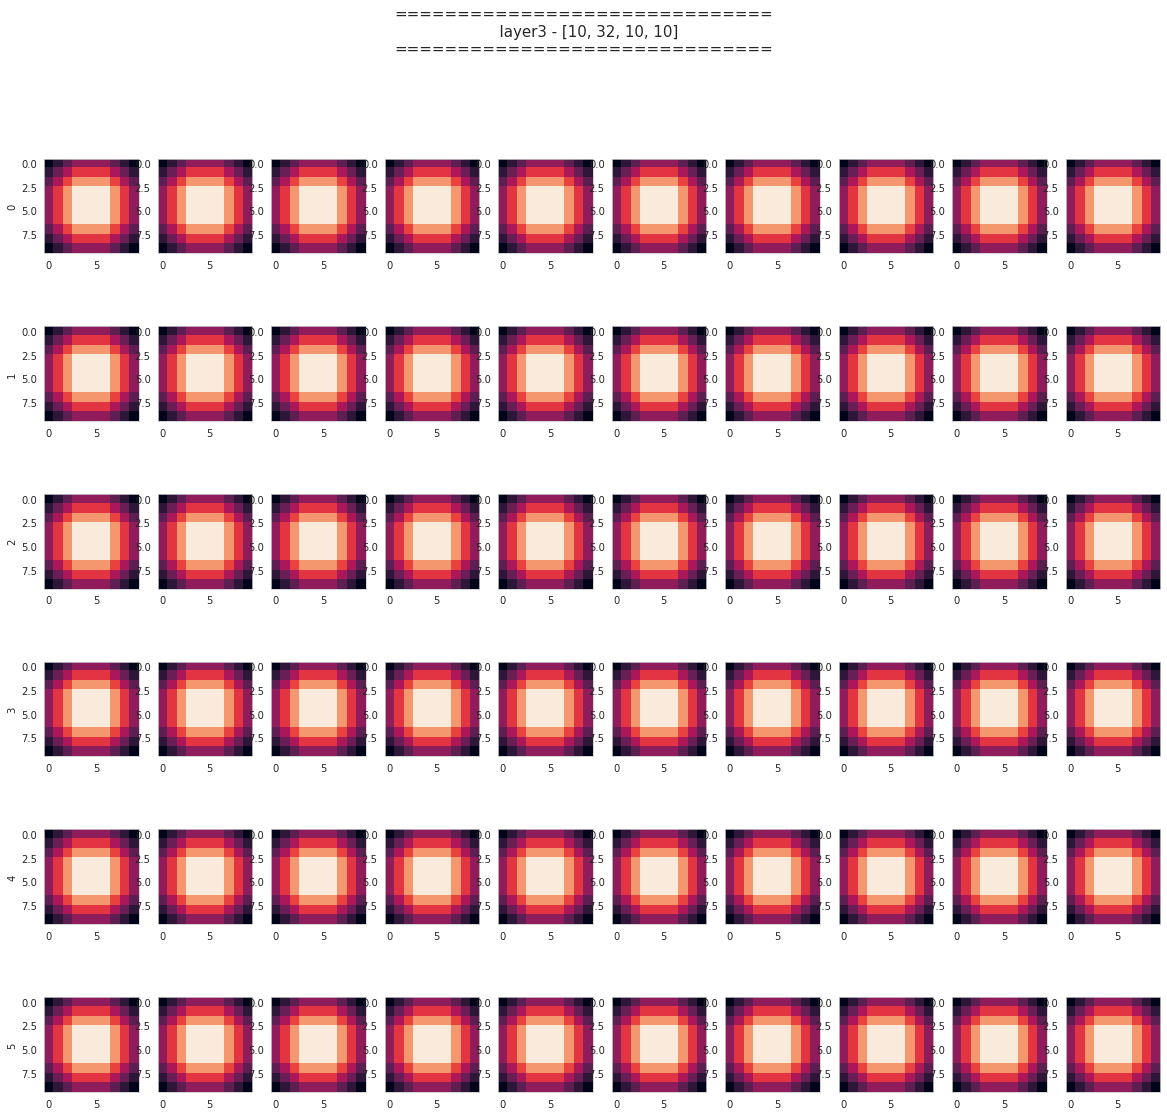

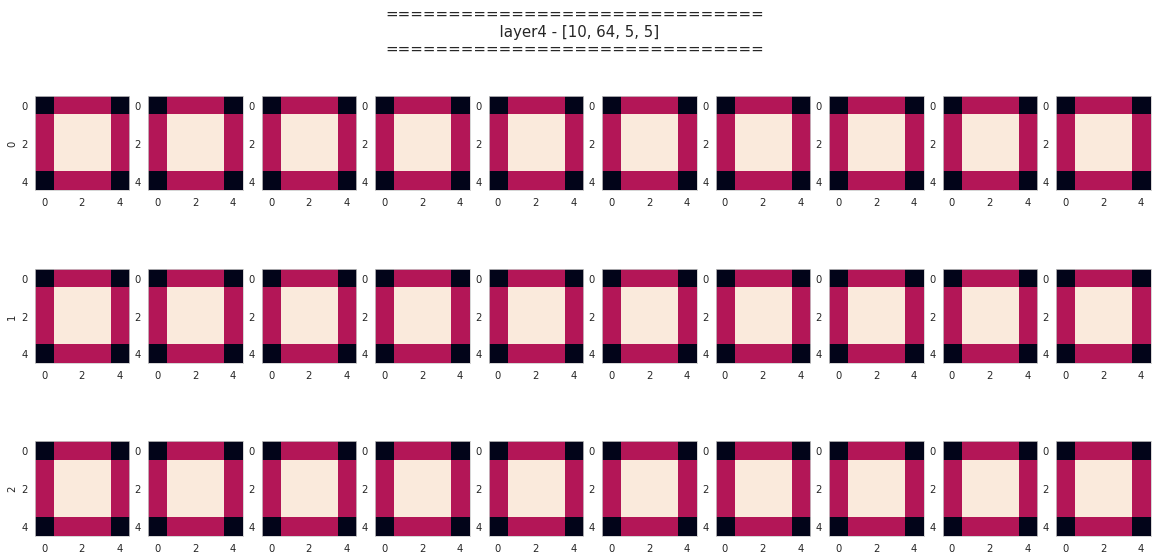

In [5]:
model_cfg = '../configs/model_cfgs/pipeline_simple_san19pair_rgbspec_168.yaml'
weight = '../pretrained/san19_epic_otherscales/168/best.model'
run_experiment(model_cfg, weight, title=weight.split('/')[-2], display=True, new_num_segments=10)

# 64x64

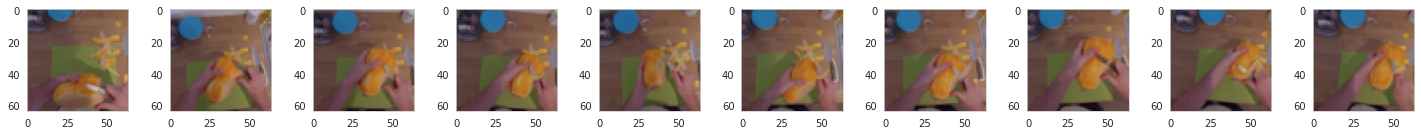

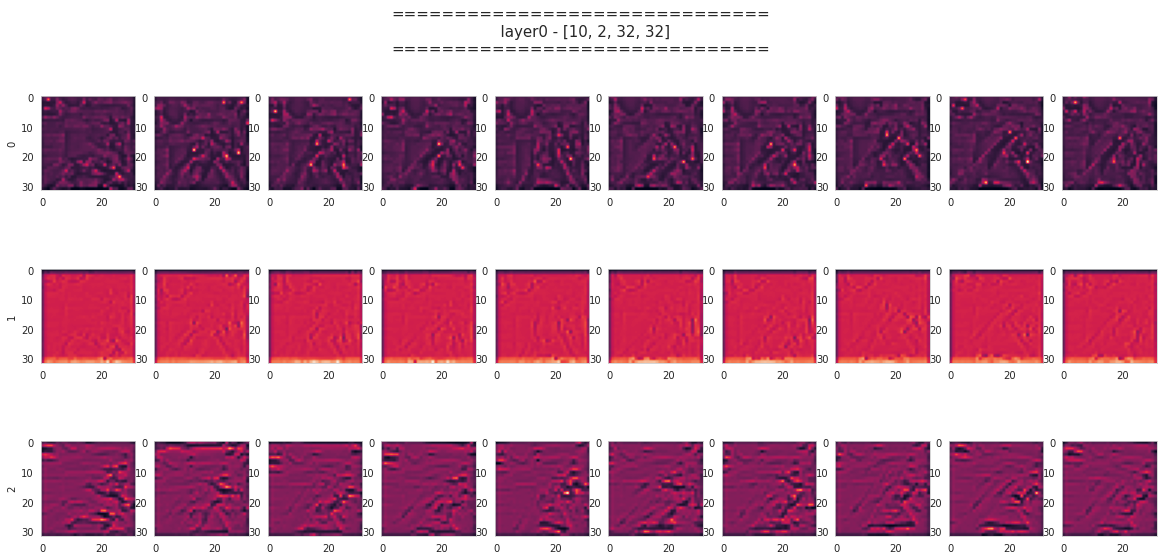

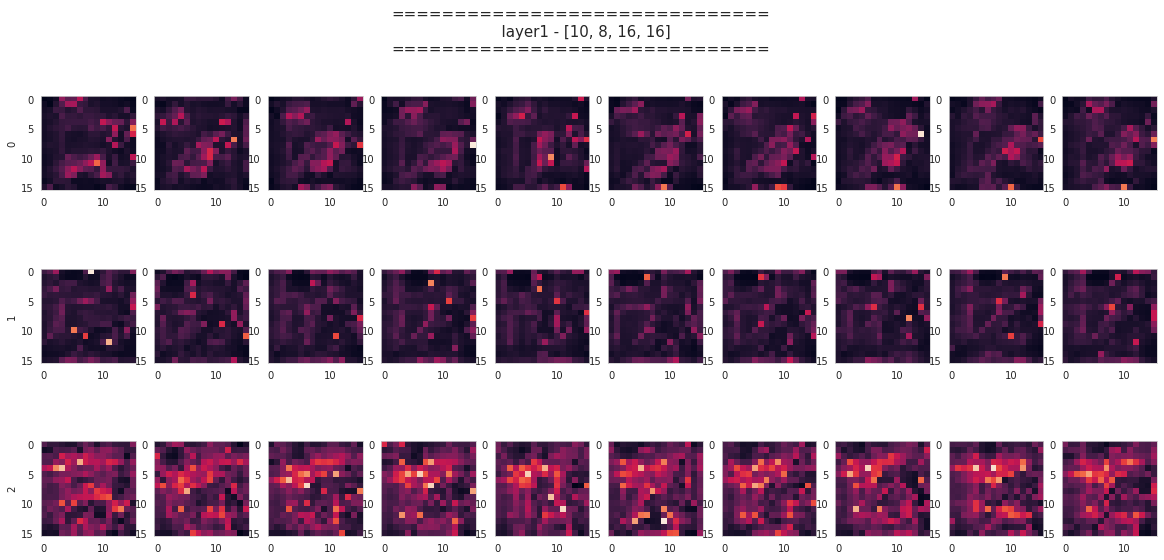

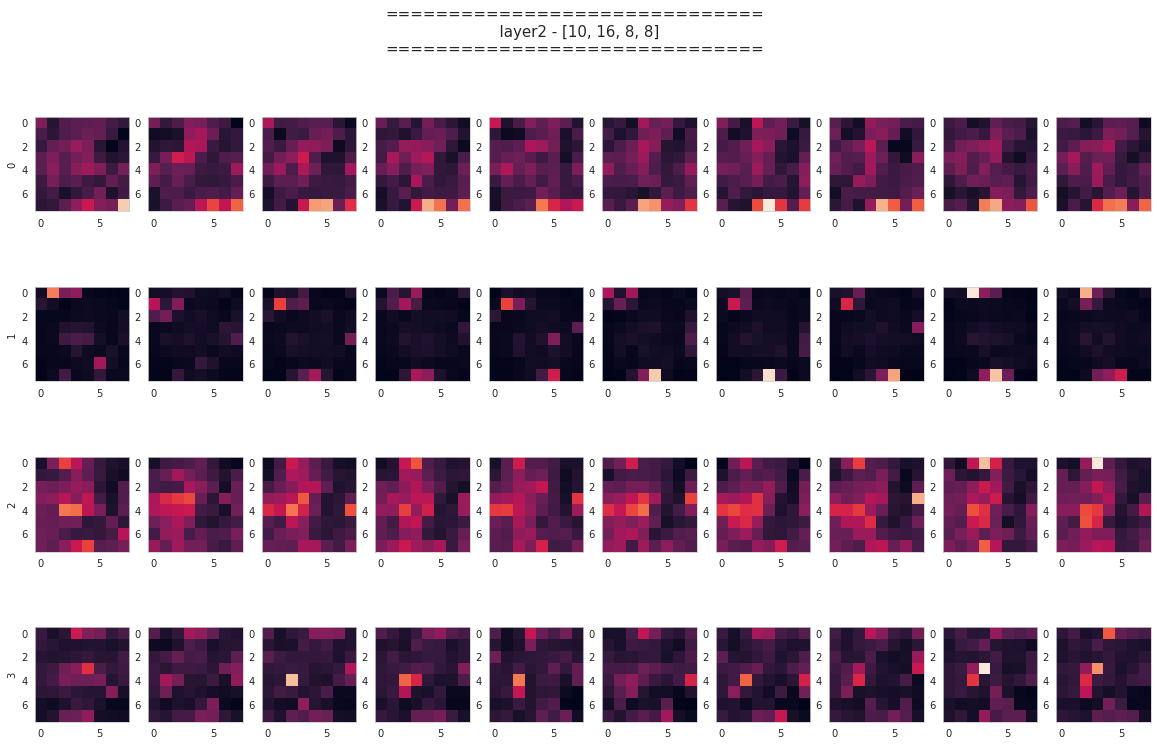

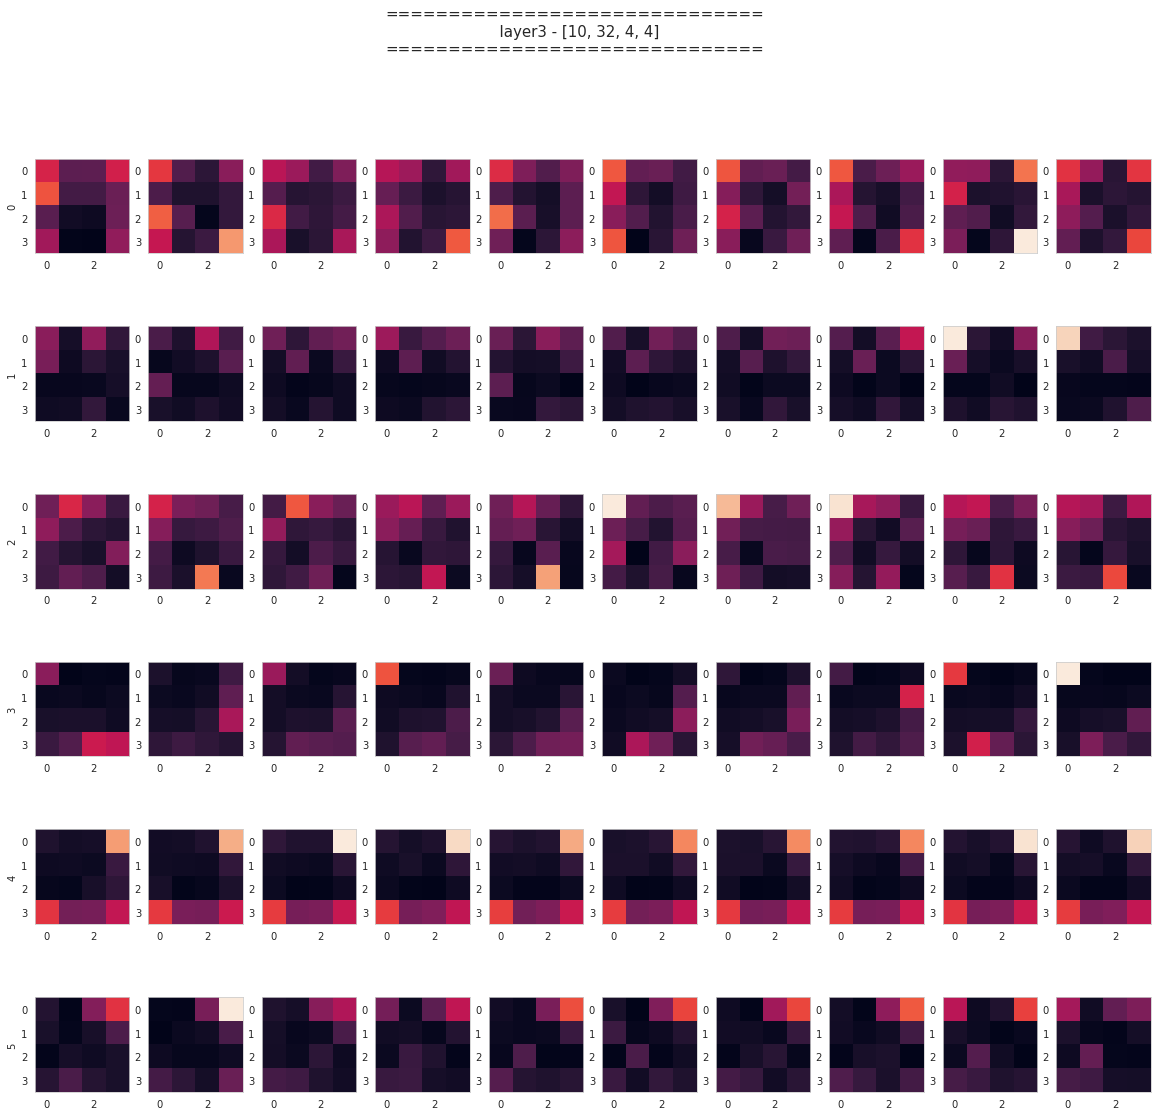

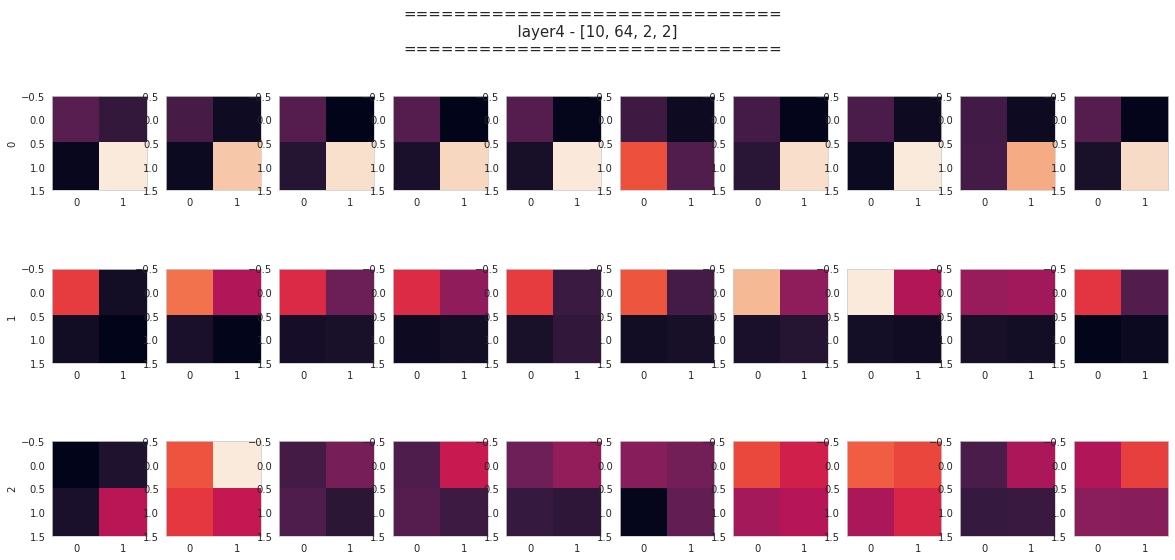

In [6]:
model_cfg = '../configs/model_cfgs/pipeline_simple_san19pair_rgbspec_64.yaml'
weight = '../pretrained/san19_epic_otherscales/64/best.model'
run_experiment(model_cfg, weight, title=weight.split('/')[-2], display=True, new_num_segments=10)